##Importar librerias

In [ ]:
!python -m spacy download es_core_news_md > a

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
import nltk
nltk.download('punkt')
import sklearn.manifold
from collections import Counter
from nltk.cluster import kmeans, cosine_distance, euclidean_distance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


##Cargar datos 

Cargamos es_core_news_md de spacy, un paquete para tener vocabulario de noticias en español.

En colab suele tener un error la siguiente linea. Si aparece un error de es_core_news_md, reiniciar el entorno de ejecucion y correr nuevamente las celdas, evitando correr la la linea: 
`!python -m spacy download es_core_news_md > a`

In [2]:
nlp = spacy.load('es_core_news_md')

Conectar con Drive, teniendo guardado en una carpeta Mineria el corpus "lavoztextodump.txt"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
drive_path = '/content/drive/MyDrive/Mineria/'
filename = "lavoztextodump.txt"
text_file = open(drive_path+filename, "r")
dataset = text_file.read()
text_file.close()


##Limpiado de datos

In [5]:
#Eliminamos los separadores de notas, para que "-" no cuente como un parrafo 
new_dataset = dataset.replace('-\n', '')

In [6]:
#Solo tomamos los primeros 1000000 de caracteres, para que lo pueda procesar spacy
doc = nlp(new_dataset[:1000000])

Luego contamos la cantidad de apariciones de cada lemma, para luego usar eso como metodo de filtrado para ver a que palabras vale la pena asignarle un cluster.

Como algunas palabras salian repetidas (por ejemplo Lo-lo, Se-se, Sin-sin) Se probo usando lowercase para los lemmas, pero genero varios errores en los clusters y las palabras que representan nombres propios desaparecieron. Por lo que la idea fue descartada, y siguen apareciendo palabras duplicadas (que en su mayoria son stopwords).


In [7]:
#Contamos la cantidad de apariciones de cada lemma 
words_lemmas = []
for sent in doc.sents:
    for word in sent:
        if word.is_alpha:
            words_lemmas.append(word.lemma_)
lemma_count = Counter(words_lemmas)

##Agregar caracteristicas 



Se van a agregar las siguientes caracteristicas:

POS__: Part of speech, para separar por tipo de palabra

DEP__: Dependencias, para ver las dependencias de la palabra dentro de la oracion.

TAG__: Tag, para ver en detalle la tag de pos.

Luego como se van a comparar metodos, las siguientes van a ser caracteristicas opcionales de cada metodo:

- TRIPLA__: La tripla de dependencia con la dependencia y el lemma de la palabra de la cual depende (head).(*)

- Contexto, en el parrafo, en la oracion, y en ambos al mismo tiempo

Todas las palabras en el parrafo y la oracion que pasan la cantidad de threshold_context de apariciones son agregadas como contexto.
Cuando se agregan ambos al mismo tiempo, las palabras que estan en la misma oracion, van a sumarse dos veces, teniendo mas valor.


En la oracion, si aparece un numero se agrega NUM__  como parte del contexto,  en vez del numero en concreto que se agrega, con esto todas las palabras que tengan numeros cerca, por ejemplo los dias de la semana, tienen una caracteristica en comun. En el parrafo se ignora para no agregar ruido, ya que en la mayoria de parrafos se va a tener una palabra de este tipo. 

(*)Para la tripla de dependencia, tambien se agrego un threshold para que solo se agreguen triplas a palabras cuyo head superan este threshold. Esto evita que se generen montones de dimensiones que en la mayoria de situaciones tendrian un 0, generando que todas las palabras se encuentren juntas. En el analisis vamos a ver que no se soluciona este problema del todo con el threshold, pero lo mejora un poco permitiendo que se pueda computar. Este threshold fue tomado de manera arbitraria, por lo que seria interesante ir probando diferentes constantes para este, y ver si alguno mejora el metodo.

Con estas decisiones, lo que se intenta obtener es palabras en un mismo cluster cuando esten relacionados los tipos textos, es decir ver clusters de politica, economia, educacion, etc.


In [8]:
#Funcion para separar en parrafors, ya que no hay una propia de spacy
def paragraphs(my_document):
    start = 0
    for token in my_document:
        if token.is_space and token.text.count("\n") >= 1:
            yield my_document[start:token.i]
            start = token.i
    yield my_document[start:]

In [9]:
# Creamos el diccionario de features de cada palabra
def create_features_dicc(with_par=True, with_sent=True, with_tripla=False, threshold_lemma=10, threshold_context=50):
  dicc = {}

  for par in paragraphs(doc):
    for word in par:
      w = word.lemma_
      if not word.is_alpha or lemma_count[w] < threshold_lemma:
          continue
      if not w in dicc:
          features = {}
      else:
          features = dicc[w]

      pos = "POS__" + word.pos_
      if not pos in features:
          features[pos] = 0
      features[pos] += 1

      dep = "DEP__" + word.dep_
      if not dep in features:
          features[dep] = 0
      features[dep] += 1

      tag = "TAG__" + word.tag_
      if not tag in features:
          features[tag] = 0
      features[tag] += 1

      if with_tripla:
        if lemma_count[word.head.lemma_]>threshold_context:
          tripla = "TRIPLA__" +  word.dep_ + "__" + word.head.lemma_
          if not tripla in features:
            features[tripla] = 0
          features[tripla] += 1

      #Agregando el contexto de los parrafos
      if with_par:
        for other_word in par:
          if other_word == word:
            continue
          if lemma_count[other_word.lemma_] > threshold_context:
            if other_word.like_num:
              continue
            else:
              context = other_word.lemma_
            if not context in features:
                features[context] = 0
            features[context] += 1

      dicc[w] = features

  #Agregando el contexto de las oraciones por separado, corriendo el documento nuevamente
  if with_sent:
    for sent in doc.sents:
      for word in sent:
        w = word.lemma_
        if not word.is_alpha or lemma_count[w] < threshold_lemma:
            continue
        if not w in dicc:
            features = {}
        else:
            features = dicc[w]
        for other_word in sent:
          if other_word == word:
            continue
          if lemma_count[other_word.lemma_] > threshold_context:
            if other_word.like_num:
              context = "NUM__"
            else:
              context = other_word.lemma_
            if not context in features:
                features[context] = 0
            features[context] += 1

        dicc[w] = features
  return dicc


In [10]:
#Con el diccionario de features de cada palabra, hacemos una lista para poder hacer una matriz,
# y guardamos en el diccionario key_words los indices de la lista para cada palabra.
def create_features_and_keywords_list(features_dicc):
  features = []
  key_words = {}
  wid = 0
  for d in features_dicc:
      if len(d) > 0:
          key_words[d] = wid
          features.append(features_dicc[d])
          wid += 1
  return features, key_words

##Clustering de datos


In [11]:
#Con la lista de features creamos una matriz para luego poder usarla con Kmeans y hacer clustering.
def create_feature_matrix(features):
  from sklearn.feature_extraction import DictVectorizer
  v = DictVectorizer(sparse=False)
  matrix = v.fit_transform(features)

  matrix_normed = matrix / matrix.max(axis=0)

  variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

  threshold_v = 0.001
  red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)
  return red_matrix

In [12]:
#Esta funcion se va a llamar para correr las funciones vistas en las celdas anteriores
# y luego el output es usado para hacer el clustering.
def proceso(with_par=True, with_sent=True, with_tripla=False):
  features_dicc = create_features_dicc(with_par, with_sent, with_tripla)
  features_list, key_words = create_features_and_keywords_list(features_dicc)
  features_matrix = create_feature_matrix(features_list)
  return features_matrix, key_words

K-means es un algoritmo de clasificación no supervisada (clusterización) que agrupa objetos en k grupos basándose en sus características. El agrupamiento se realiza minimizando la suma de distancias entre cada objeto y el centroide de su grupo o cluster. Se va a probar clusterizar con distancia coseno y distancia euclidea.

In [13]:
#Hacemos clustering con Kmeans.
#is_cosine determina si usamos la distancia coseno o la euclidea.
def clustering(n_clusters, features_matrix, is_cosine=True):
  if is_cosine:
    distance = cosine_distance
  else:
    distance = euclidean_distance
  clusterer = kmeans.KMeansClusterer(n_clusters, distance, avoid_empty_clusters=True)
  clusters = clusterer.cluster(features_matrix, True)
  return clusters

##Visualizacion de datos

In [14]:
#VISUALIZAR
def create_pandas_DF(features_matrix, key_words):
  tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
  matrix_dicc2d = tsne.fit_transform(features_matrix)
  pointsspacy = pd.DataFrame(
      [
          (word, coords[0], coords[1])
          for word, coords in [
              (word, matrix_dicc2d[key_words[word]])
              for word in key_words
          ]
      ],
      columns=["word", "x", "y"]
  )
  return pointsspacy, tsne, matrix_dicc2d

def create_pandas_DF_cluster(features_matrix, key_words, clusters, tsne, matrix_dicc2d):
  pointscluster = pd.DataFrame(
      [
          (word, coords[0], coords[1], cluster)
          for word, coords, cluster in [
              (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
              for word in key_words
          ]
      ],
      columns=["word", "x", "y", "c"]
  )
  return pointscluster

#plotear los puntos antes y despues de la clusterizacion
def plot(pointsspacy, pointscluster, method):
  fig, axes = plt.subplots(nrows=1, ncols=2)
  pointsspacy.plot.scatter(ax=axes[0],x='x', y='y', cmap='viridis', s=10, figsize=(20, 10)); axes[0].set_title(f'{method}')
  pointscluster.plot.scatter(ax=axes[1],x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 10)); axes[1].set_title(f'{method} dividido por clusters')

##Ejecucion y analisis

In [15]:
#Para tener la lista de clusters y
# una lista de todas las palabras con cluster
def get_all_clusters(clusters, key_words):
  words_seen = []
  my_clusters = [[]]
  i = 0 
  for word in key_words:
    if word in words_seen:
      continue
    words_seen.append(word)
    my_clusters.append([word])
    for w2 in key_words:
      if w2 in words_seen:
        continue
      if clusters[key_words[w2]] == clusters[key_words[word]]:
          words_seen.append(w2)
          my_clusters[i].append(w2)
  return my_clusters, words_seen

In [16]:
# Obtener un grupo random de num_pairs palabras, para luego chequear si estan
# en el mismo cluster y evaluar si deberian estarlo o no
def get_random_pairs(words, num_pairs=10):
  from random import randint
  count_lemmas = len(words)
  random_pairs = []
  for i in range(num_pairs):
    first_index = randint(0, count_lemmas-1)
    second_index = randint(0, count_lemmas-1)
    first_random = words[first_index]
    second_random = words[second_index]
    random_pairs.append([first_random, second_random])
  return random_pairs

In [17]:
##Conseguir pares random de palabras
# all_clusters, all_words = get_all_clusters(clusters, key_words) 
# get_random_pairs(all_words)


Para medir de alguna forma un metodo de clustering buscamos una lista random de pares de palabras y nos fijamos si deberian o no estar en el mismo cluster. Luego vemos si nuestro metodo de clustering tuvo los mismos resultados que pensamos en un principio.

Llammando a get_all_clusters obtenemos como primer elemento una lista de listas de palabras, donde cada sublista es un cluster (se puede usar para revisar los clusters manualmente). En el segundo elemento obtenemos una lista de todas las palabras que tienen un cluster.

Con la lista de palabras llamamos a get_random_pairs para obtener una lista de pares random de palabras y para luego chequear si deberian estar en el mismo cluster.
Tome la siguiente lista random de pares:

```
[['emergencia', 'Fundación'], ['rondar', 'Clarín'],
 ['investigar', 'juzgar'], ['Tampoco', 'recibir'],
 ['método', 'elegir'], ['igual', 'presionar'],
 ['posición', 'tratamiento'], ['usar', 'número'],
 ['autor', 'juez'], ['tocar', 'extranjero']]
 ```
y decidi que el par `['investigar', 'juzgar']` era el unico con sentido de estar en un mismo cluster.

 Para cada metodo de clustering se va a medir cuantos de estos pares estuvieron correctos. Ademas cuantos de los siguientes grupos de palabras que considero que deberian pertenecer a un mismo cluster lo estan, o estan en parte, midiendo cuantos clusters se crearon por grupo:

Dias de la semana:
```
['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']
```
 Nombres propios:
 ```
['Alfredo', 'Roberto', 'Oscar', 'Gustavo', 'Eduardo', 'Walter', 'Ricardo', 'Marcelo', 'Rafael', 'Jorge', 'Sergio', 'Héctor']
 ```
Relacionados a educacion:
```
['Universidad', 'Facultad', 'colegio', 'educacion']
```
Paises de latinoamerica:
```
[ 'Brasil', 'Chile', 'Cuba', 'Bolivia', 'Colombia', 'Perú', 'Uruguay', 'México', 'Argentina', 'Ecuador', 'Venezuela', 'Honduras']
```
Funcionarios públicos Brasil:
```
['Luiz', 'Lula', 'Silva', 'Dilma', 'Rousseff']
```
Funcionarios públicos Cordoba:
```
['Díaz', 'Sota', 'Schiaretti', 'Mestre', 'Vigo', 'Giacomino', 'Kirchner', 'Aguad']

```

In [18]:
#Constantes con las listas a evaluar
PARES = [['emergencia', 'Fundación'], ['rondar', 'Clarín'], ['investigar', 'juzgar'], ['Tampoco', 'recibir'], ['método', 'elegir'], ['igual', 'presionar'], ['posición', 'tratamiento'], ['usar', 'número'], ['autor', 'juez'], ['tocar', 'extranjero']]
DIAS = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes', 'sábado', 'domingo']
NOMBRES = ['Alfredo', 'Roberto', 'Oscar', 'Gustavo', 'Eduardo', 'Walter', 'Ricardo', 'Marcelo', 'Rafael', 'Jorge', 'Sergio', 'Héctor']
EDUCACION = ['Universidad', 'Facultad', 'colegio', 'educación']
LATINOAMERICA = [ 'Brasil', 'Chile', 'Cuba', 'Bolivia', 'Colombia', 'Perú', 'Uruguay', 'México', 'Argentina', 'Ecuador', 'Venezuela', 'Honduras']
FUNC_BR = ['Luiz', 'Lula', 'Silva', 'Dilma', 'Rousseff']
FUNC_CBA = ['Díaz', 'Sota', 'Schiaretti', 'Mestre', 'Vigo', 'Giacomino', 'Kirchner', 'Aguad']
LISTAS_CONSTANTES = {'DIAS':DIAS,
                    'NOMBRES':NOMBRES,
                    'EDUCACION': EDUCACION,
                    'LATINOAMERICA': LATINOAMERICA,
                    'FUNC_BR': FUNC_BR,
                    'FUNC_CBA': FUNC_CBA}

Para los pares de palabras, se saca el procentaje de ser un par correcto (donde el unico par que tiene que estar en el mismo cluster es 'investigar' con 'juzgar').

Para las listas de palabras, que fueron consideradas como que tienen que estar en el mismo cluster, se cuentan las cantidades de clusters distintos en los que estan las palabras de la lista. Si solo hay un cluster, se considera 100% de acierto. Cuando hay mas de un cluster, se aplica la formula `numero de palabras - numero de clusters / numero de palabras` y se lo multiplica por 100 para obtener el porcentaje. Asi, a medida que haya mas clusters, el porcentaje va a bajar.

Con estas medidas, se van a comparar los distintos metodos de clustering y ver cual tuvo mejor rendimiento.
Es importante recalcar que no se penaliza, salvo en la parte de ver pares, cuando un cluster tiene demasiadas palabras, por ejemplo si un cluster tiene todos los grupos elegidos juntos, nos daria un puntaje muy bueno pero no seria una buena solucion de clustering.

Las siguientes son las funciones para calcular que tan acertado fue el clustering.


In [19]:
#Funcion para ver en cuantos clusters distintos se encuentra una lista de palabras
def amount_of_clusters(words, clusters, key_words):
  clusters_list = []
  for word in words:
    clusters_list.append(clusters[key_words[word]])
  clusters_set = set(clusters_list)
  return len(clusters_set)

def same_cluster_percentage(n_clus, n_words):
  if n_clus == 1:
    return 100
  else:
    return round(100* (n_words - n_clus) / n_words)

def get_percentage_pares(clusters, key_words):
  percentage_pares = 0
  for par in PARES:
    nclus = amount_of_clusters(par, clusters, key_words)
    if par ==['investigar', 'juzgar']:
      percentage_pares += 1 if nclus == 1 else 0
    else:
      percentage_pares += 1 if nclus == 2 else 0
  percentage_pares = round(100 * percentage_pares/ len(PARES))
  return percentage_pares

def get_percentage_lista(clusters, key_words):
  nclus = []
  dict_percentages = {}
  for key in LISTAS_CONSTANTES:
    nclus = amount_of_clusters(LISTAS_CONSTANTES[key], clusters, key_words)
    list_percentage = same_cluster_percentage(nclus, len(LISTAS_CONSTANTES[key]))
    dict_percentages[key] = list_percentage
  return dict_percentages

Inicializamos un diccionario para las caracteristicas que van a tener nuestros diferentes metodos de clustering, y tambien una lista para el tipo de cluster, la cual tiene pares que representan la cantidad de clusters que va a tener esa corrida y si va a ser con distancia coseno (True) o distancia euclidea (False).


Como se hablo anteriormente, el objetivo es encontrar grupos de palabaras separadas por tipo de texto. Veremos que caracteristicas maximizan este objetivo.

In [20]:
CLUSTER_METHODS = {'Sen': {'with_par':False,
                                'with_sent':True, 
                                'with_tripla':False},
                  'Par': {'with_par':True,
                                'with_sent':False, 
                                'with_tripla':False},
                   'Par&Sen': {'with_par':True,
                                'with_sent':True, 
                                'with_tripla':False},
                   'Full': {'with_par':True,
                                'with_sent':True, 
                                'with_tripla':True},

}
TYPE_CLUSTER = [(50, True), (75, True), (100, True), (125, True), (150, True), (50, False), (75, False), (100, False), (125, False), (150, False)]

 Aqui corremos todo el flujo, para crear los clusters para cada metodo y obtener las estadisticas, para luego hacer las comparaciones.
Al ser muchos metodos, puede tardar cerca de 1 hora.

In [21]:
statistics_clusters = {}
plots_clusters = {}
for method in CLUSTER_METHODS:
  print("Starting with method:", method)
  features_matrix, key_words = proceso(**CLUSTER_METHODS[method])
  pointsspacy, tsne, matrix_dicc2d = create_pandas_DF(features_matrix, key_words)
  for n_clusters, is_cosine in TYPE_CLUSTER:
    percentage_methods = {}
    print("number of clusters:", n_clusters)
    print("using cosine distance:", is_cosine)
    clusters = clustering(n_clusters, features_matrix, is_cosine)
    if n_clusters == 100:
      pointscluster = create_pandas_DF_cluster(features_matrix, key_words, clusters, tsne, matrix_dicc2d)
      plots_clusters[f'{method}_{n_clusters}_{is_cosine}'] = (pointsspacy, pointscluster)
    percentage_methods['pares'] = get_percentage_pares(clusters, key_words)
    percentage_listas = get_percentage_lista(clusters, key_words)
    percentage_methods.update(percentage_listas)
    statistics_clusters[f'{method}_{n_clusters}_{is_cosine}'] = percentage_methods
    print("Finished")
  print("Method finished")

Starting with method: Sen
number of clusters: 50
using cosine distance: True
Finished
number of clusters: 75
using cosine distance: True
Finished
number of clusters: 100
using cosine distance: True
Finished
number of clusters: 125
using cosine distance: True
Finished
number of clusters: 150
using cosine distance: True
Finished
number of clusters: 50
using cosine distance: False
Finished
number of clusters: 75
using cosine distance: False
Finished
number of clusters: 100
using cosine distance: False
Finished
number of clusters: 125
using cosine distance: False
Finished
number of clusters: 150
using cosine distance: False
Finished
Method finished
Starting with method: Par
number of clusters: 50
using cosine distance: True
Finished
number of clusters: 75
using cosine distance: True
Finished
number of clusters: 100
using cosine distance: True
Finished
number of clusters: 125
using cosine distance: True
Finished
number of clusters: 150
using cosine distance: True
Finished
number of clusters

###Primeros resultados

In [22]:
#imprimimos todos los puntajes y guardamos el metodo con mayor puntaje.
i=1
max_stat = 0
max_method = ''
for s in statistics_clusters:
  stats = statistics_clusters[s]
  print(i, s, stats)
  sum_stat = stats['pares'] + stats['DIAS']+ stats['NOMBRES']+ stats['EDUCACION']+ stats['LATINOAMERICA']+ stats['FUNC_BR']+ stats['FUNC_CBA']
  if sum_stat >= max_stat:
    max_stat = sum_stat
    max_method = s
  i+=1

1 Sen_50_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 75, 'FUNC_BR': 100, 'FUNC_CBA': 75}
2 Sen_75_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 83, 'FUNC_BR': 100, 'FUNC_CBA': 62}
3 Sen_100_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 67, 'FUNC_BR': 100, 'FUNC_CBA': 75}
4 Sen_125_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 67, 'FUNC_BR': 60, 'FUNC_CBA': 75}
5 Sen_150_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 75, 'EDUCACION': 0, 'LATINOAMERICA': 67, 'FUNC_BR': 100, 'FUNC_CBA': 75}
6 Sen_50_False {'pares': 90, 'DIAS': 100, 'NOMBRES': 83, 'EDUCACION': 25, 'LATINOAMERICA': 75, 'FUNC_BR': 40, 'FUNC_CBA': 75}
7 Sen_75_False {'pares': 100, 'DIAS': 100, 'NOMBRES': 83, 'EDUCACION': 25, 'LATINOAMERICA': 75, 'FUNC_BR': 40, 'FUNC_CBA': 75}
8 Sen_100_False {'pares': 90, 'DIAS': 100, 'NOMBRES': 83, 'EDUCACION': 0, 'LATINOAMERICA': 67, 'FUNC_BR': 60, '

Lo primero que podemos notar con los resultados es que por lo general para los pares de palabras random hubieron buenos resultados, excepto para las opciones full y False ( con distancia euclidea que incluyen tripla de dependencia). Esto es porque al juntarse mucho todas las palabras, al algoritmo de clustering le cuesta hacer una buena separacion entre estas palabras. Se puede ver que por lo general a los metodos Full les ha ido bastante mal, en todos los grupos de palabras elegidos, por la misma razon.

Tambien se puede ver que por lo general, si se compara a metodos con las mismas caracteristicas pero con distincia diferente, son mejores en los que se utilizo la distancia coseno (que tienen True al final del nombre).

A continuacion un ejemplo:

In [40]:
s_cos = 'Par&Sen_50_True'
print(i, s_cos, statistics_clusters[s_cos])
s_euc = 'Par&Sen_50_False'
print(i, s_euc, statistics_clusters[s_euc])


41 Par&Sen_50_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 75, 'FUNC_BR': 100, 'FUNC_CBA': 75}
41 Par&Sen_50_False {'pares': 90, 'DIAS': 100, 'NOMBRES': 83, 'EDUCACION': 25, 'LATINOAMERICA': 75, 'FUNC_BR': 60, 'FUNC_CBA': 62}


Otra cosa llamativa de las estadisticas es que en la lista de educacion por lo general se tiene bajo porcentaje. Esto ocurre porque a diferencia de con las otras listas, esta fue creada sin mirar clusters que se habian formado en iteraciones anteriores, fue un conjunto de palabras al azar que tenian sentido que esten relacionadas. Es interesante ver que en el metodo de triplas con distancia euclidea se obtuvo mas puntaje que en los otros. Pero nuevamente esto puede ser a causa de que hay clusters muy grandes.


Por ultimo podemos notar que con una cantidad de 75-100 clusters se obtuvo mejores resultados por lo general.

Vemos finalmente cual es el metodo con mejor rendimiento:

In [39]:
print(f'El mejor metodo fue: {max_method}. Con un puntaje de: {max_stat}, ({round(max_stat/6)}% de acierto en los benchmarks) ' )
print(statistics_clusters[max_method] )

El mejor metodo fue: Par&Sen_75_True. Con un puntaje de: 550, (92% de acierto en los benchmarks) 
{'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 75, 'FUNC_BR': 100, 'FUNC_CBA': 75}


Se puede ver como el mejor metodo fue el que combino el contexto de la oracion y el parrafo usando la distancia coseno y con 75 clusters.

Por supuesto que esto no significa que realmente sea el mejor metodo, ya que depende mucho de los benchmarks que elejimos, y de la randomicidad que aporta el algoritmo de Kmeans.

### Visualizacion de los metodos

Ploteamos para cada metodo como se ubicaron las palabras en el espacio (habiendo reducido la dimensionalidad a 2) y como se formaron los clusters en cada espacio (con numero de clusters = 100).

De alguna forma se pueden ver similitudes rotando el espacio entre las ubicaciones de palabras en los graficos sin triplas de dependencia.

En cambio, cuando se agrego la tripla, se ve como todas las palabras se reunen en cerca del centro, (con algunos pequeños grupos distinguibles).

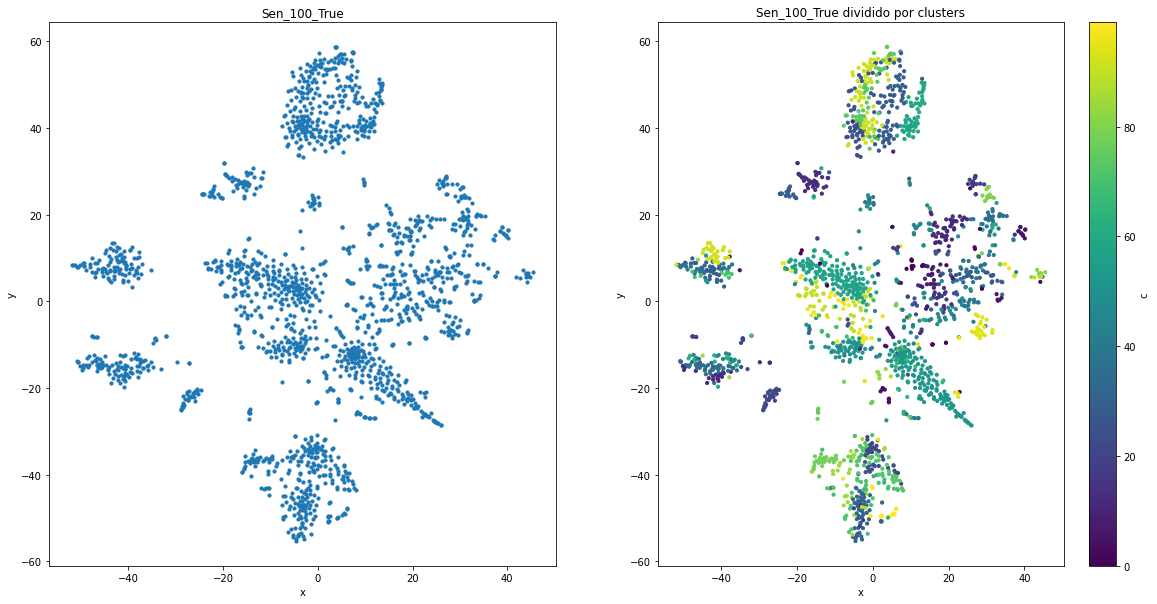

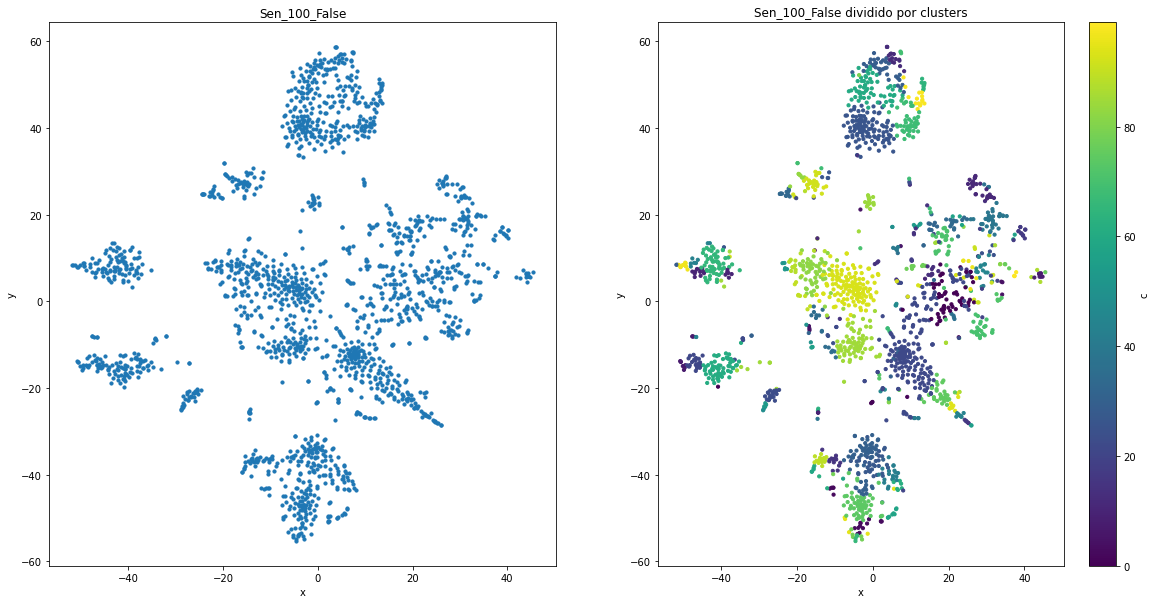

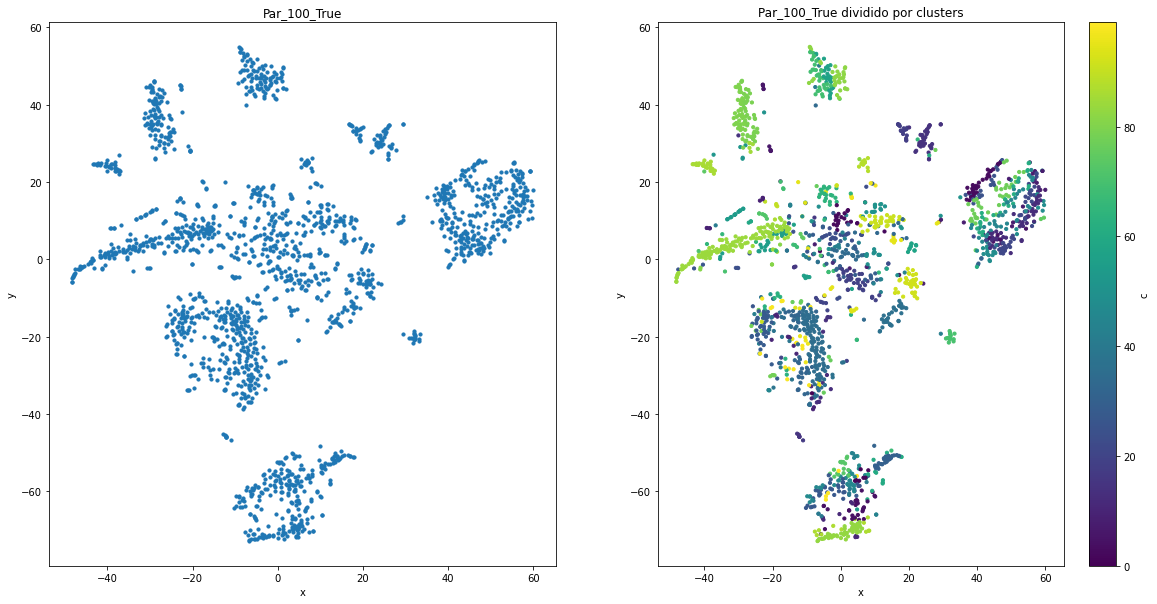

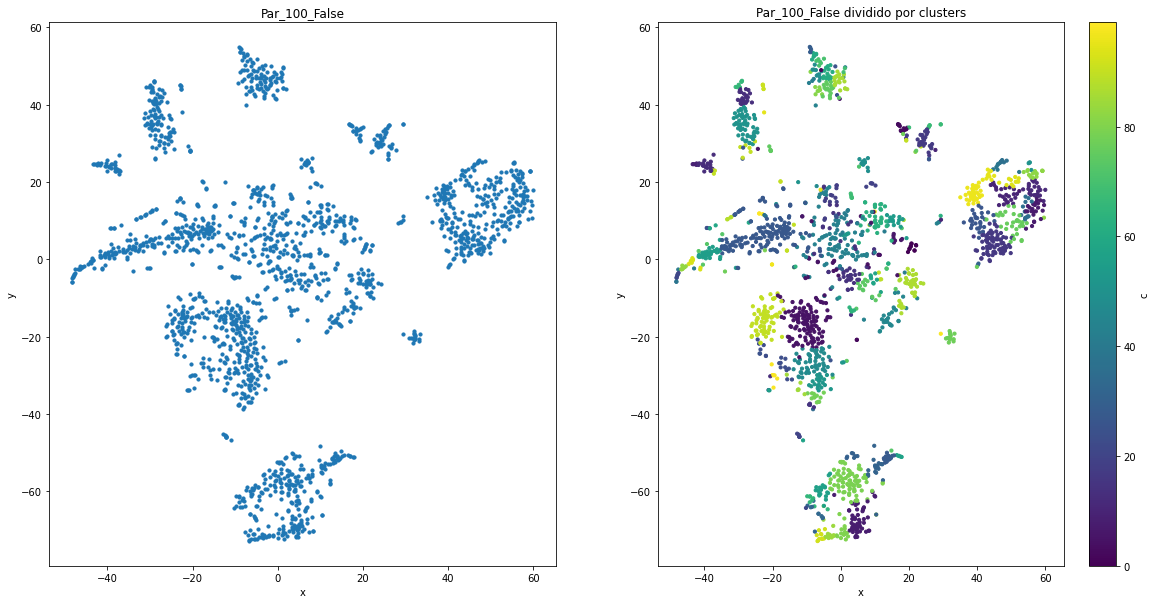

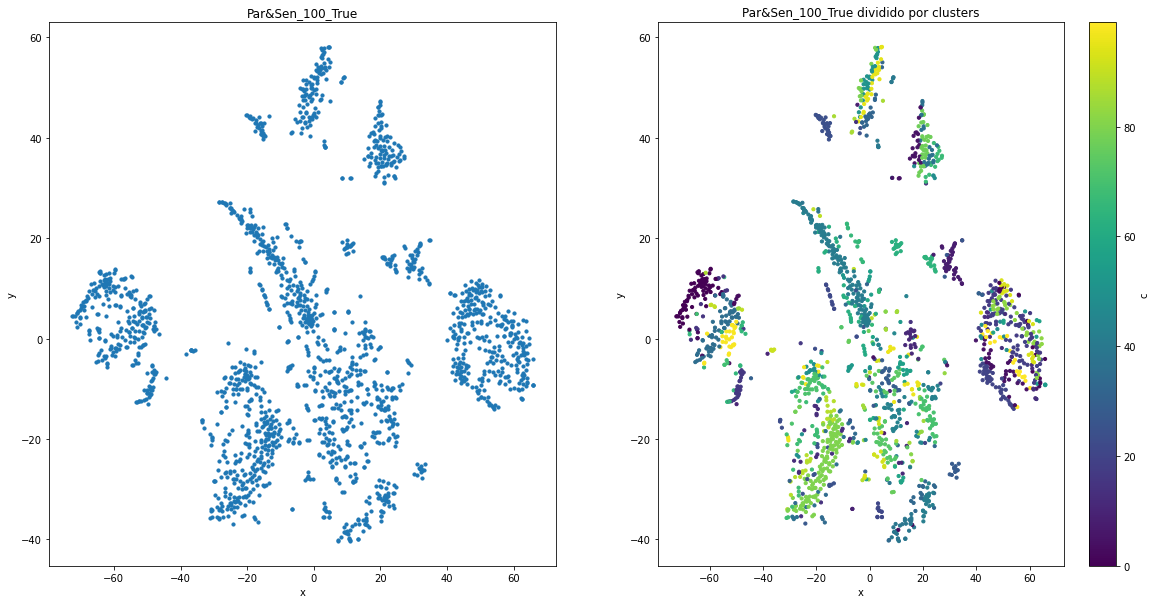

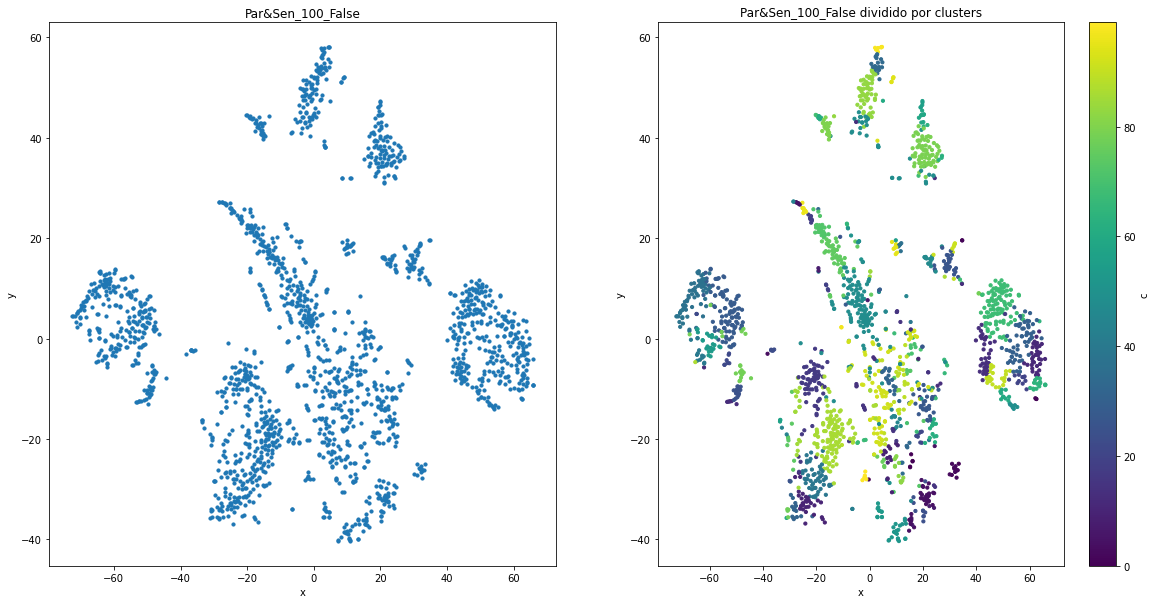

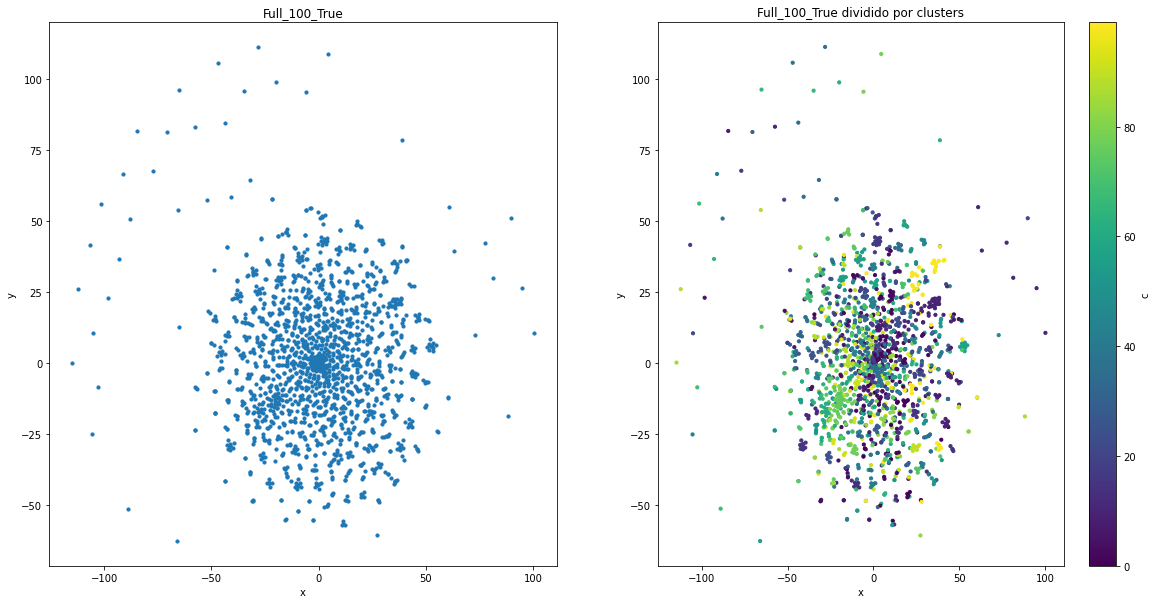

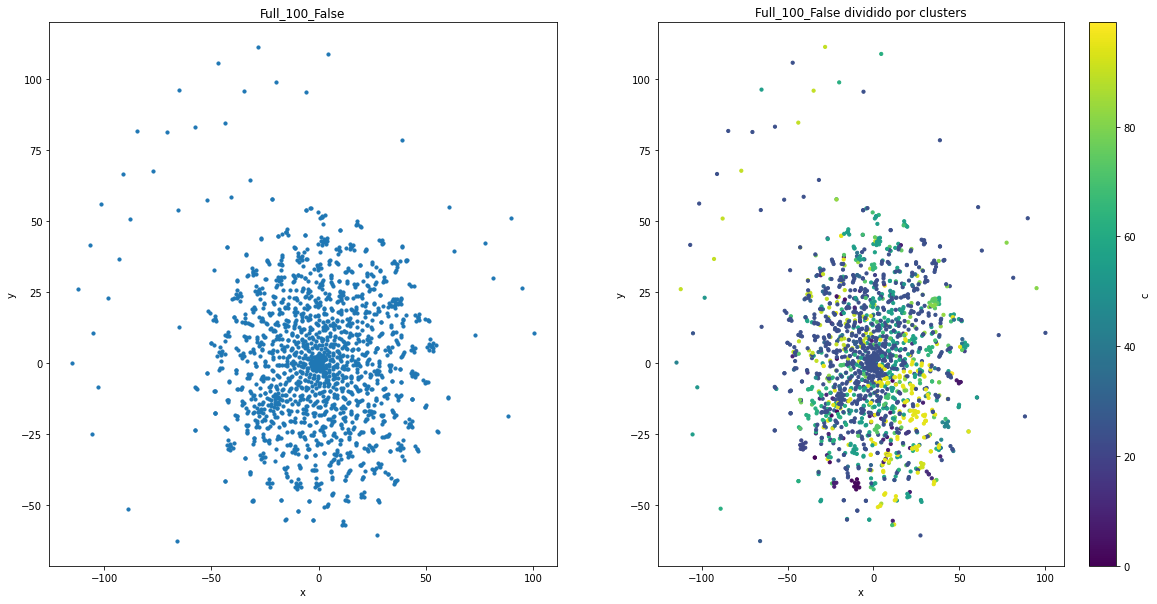

In [23]:
for method in plots_clusters:
  pointsspacy, pointscluster = plots_clusters[method]
  plot(pointsspacy, pointscluster, method)

# Embeddings

La singular-value decomposition/ SVD es una técnica de reducción de dimensión para matrices que reduce la matriz a su componente para simplificar el cálculo. Funciona muy bien con datos que tienen muchos 0, como es el caso de nuestras matrices con la tripla como caracteristica.

Ahora que obtuvimos el metodo con mejor rendimiento,
vamos a correrlo nuevamente y comparar sus estadisticas utilizando embeddings, 
tambien vamos a correr el metodo agregando la tripla de dependencia como caracteristica y aplicarle a esta embedding, ya que la manipulacion que hace en el espacio puede mejorar la diferencia entre los pequeños grupos distinguibles que se hacen con la tripla.

Funcion para hacer embeddings, reduciendo a 50 la dimensionalidad, utilizando la reduccion de sklearn.

In [25]:
from sklearn.decomposition import TruncatedSVD
def matrix_embedding(features_matrix):
  svd = TruncatedSVD(n_components=50)
  svd_matrix = svd.fit_transform(features_matrix)
  return svd_matrix

In [26]:
#obtenemos las caracteristicas del mejor metodo nuevamente 
mmstrings = max_method.split("_")
m_method_name = mmstrings[0]
m_n_clusters = int(mmstrings[1])
m_is_cosine = mmstrings[2]=='True'

Funcion para correr clustering, generar estadisticas y graficos una ultima vez (correr el flujo nuevamente)

In [27]:
def final_stats(features_matrix, key_words, method_name, n_clusters, is_cosine):
  percentage_methods = {}
  pointsspacy, tsne, matrix_dicc2d = create_pandas_DF(features_matrix, key_words)
  clusters = clustering(n_clusters, features_matrix, is_cosine)
  pointscluster = create_pandas_DF_cluster(features_matrix, key_words, clusters, tsne, matrix_dicc2d)
  percentage_methods['pares'] = get_percentage_pares(clusters, key_words)
  percentage_listas = get_percentage_lista(clusters, key_words)
  percentage_methods.update(percentage_listas)
  final_statistics[f'{method_name}_{n_clusters}_{is_cosine}'] = percentage_methods
  final_plots[f'{method_name}_{n_clusters}_{is_cosine}'] = (pointsspacy, pointscluster)
  return final_statistics, final_plots, clusters

vamos a guardar en final_statistics los porcentajes de aciertos de estos 4 metodos para compararlos y en final_plots los plots tambien para compararlos. Primero de el metodo ganador y del metodo ganador usando tripla.

In [28]:
final_statistics = {}
final_plots = {}
m_method = CLUSTER_METHODS[m_method_name]

m_features_matrix, m_key_words = proceso(**m_method)
final_statistics, final_plots, m_clusters = final_stats(m_features_matrix, m_key_words, m_method_name, m_n_clusters, m_is_cosine)


tripla_m_method = m_method.copy()
tripla_m_method['with_tripla'] = True
tripla_m_method_name = f'{m_method_name}-Tripla'

tripla_m_features_matrix, tripla_m_key_words = proceso(**tripla_m_method)
tripla_st, tripla_plots, tripla_clusters = final_stats(tripla_m_features_matrix, tripla_m_key_words, tripla_m_method_name, m_n_clusters, m_is_cosine)

final_statistics.update(tripla_st)
final_plots.update(tripla_plots)



Usamos matrix_embedding para reducir la dimensionalidad de la matriz y luego llamamos a final_stats para correr clustering y generar las estadisticas y graficos. Y asi comparar usando embeddings en el metodo ganador y ganador c/tripla.

In [29]:
emb_m_features_matrix= matrix_embedding(m_features_matrix)
emb_stats, emb_plots, emb_clusters = final_stats(emb_m_features_matrix, m_key_words, f'{m_method_name}-Emb', m_n_clusters, m_is_cosine)
final_statistics.update(emb_stats)
final_plots.update(emb_plots)

emb_tripla_m_features_matrix= matrix_embedding(tripla_m_features_matrix)
tripla_emb_stats, tripla_emb_plots, tripla_emb_clusters = final_stats(emb_tripla_m_features_matrix, tripla_m_key_words, f'{tripla_m_method_name}-Emb', m_n_clusters, m_is_cosine)
final_statistics.update(tripla_emb_stats)
final_plots.update(tripla_emb_plots)

Obtenemos las estadisticas finales.

In [30]:
for stat in final_statistics:
  stats = final_statistics[stat]
  print(stat, stats)

Par&Sen_75_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 0, 'LATINOAMERICA': 75, 'FUNC_BR': 100, 'FUNC_CBA': 75}
Par&Sen-Tripla_75_True {'pares': 90, 'DIAS': 57, 'NOMBRES': 75, 'EDUCACION': 0, 'LATINOAMERICA': 50, 'FUNC_BR': 20, 'FUNC_CBA': 50}
Par&Sen-Emb_75_True {'pares': 100, 'DIAS': 100, 'NOMBRES': 100, 'EDUCACION': 25, 'LATINOAMERICA': 67, 'FUNC_BR': 40, 'FUNC_CBA': 75}
Par&Sen-Tripla-Emb_75_True {'pares': 90, 'DIAS': 57, 'NOMBRES': 58, 'EDUCACION': 0, 'LATINOAMERICA': 33, 'FUNC_BR': 40, 'FUNC_CBA': 25}


Si comparamos los primeros dos, vemos como la tripla de dependencia nos hizo bajar la performance en todas las listas de palabras.

Comparando el primero y el tercero, podemos ver que agregando embeddings en este metodo, mejoro un poco el grupo de educacion, pero hubo una baja en el de latinoamerica y el de funcionarios de Brasil.

Por ultimo, comparando entre el 2 y 4 vemos que al aplicarle al de tripla un embedding, solo tuvimos una pequenia mejora en un grupo y empeoraron otros, muy probablemente porque el embedding hizo que se separen algunos de estos clusters mas grandes que no estaban tan relacionados.

Obtenemos los utlimos graficos, se puede notar la diferencia entre los grupos de triplas con y sin embedding (graficos 3 y  7) como cambio el espacio rotundamente.

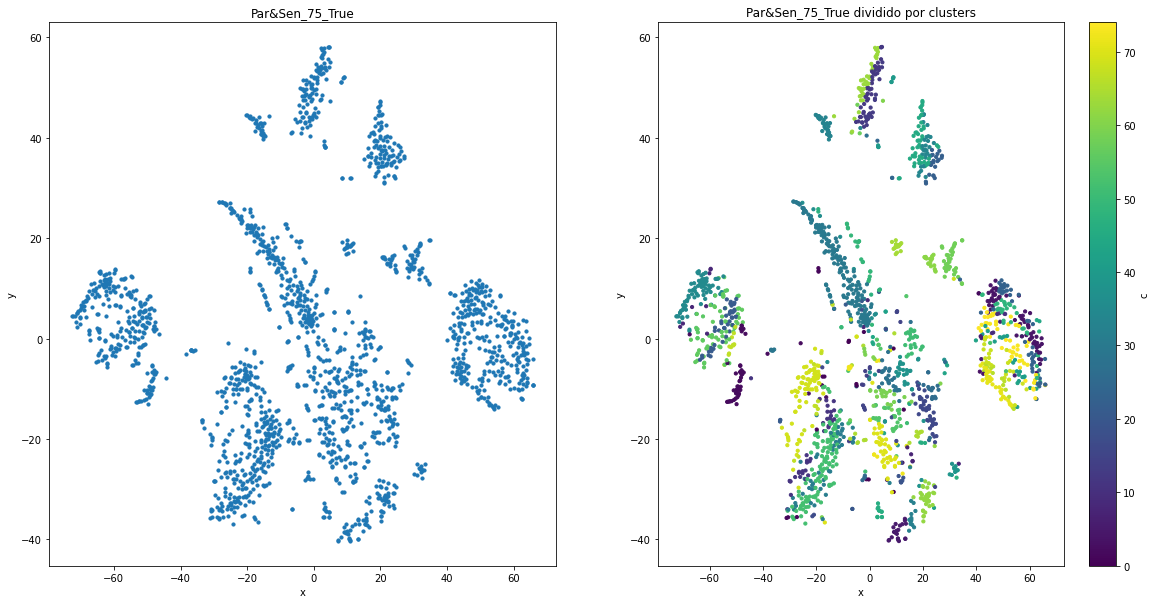

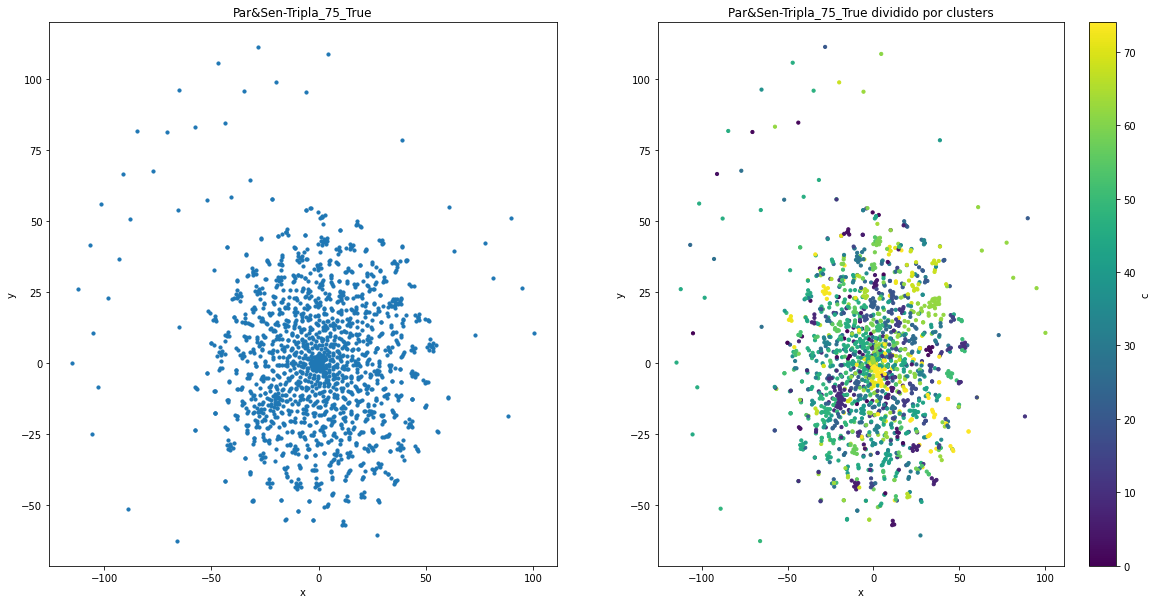

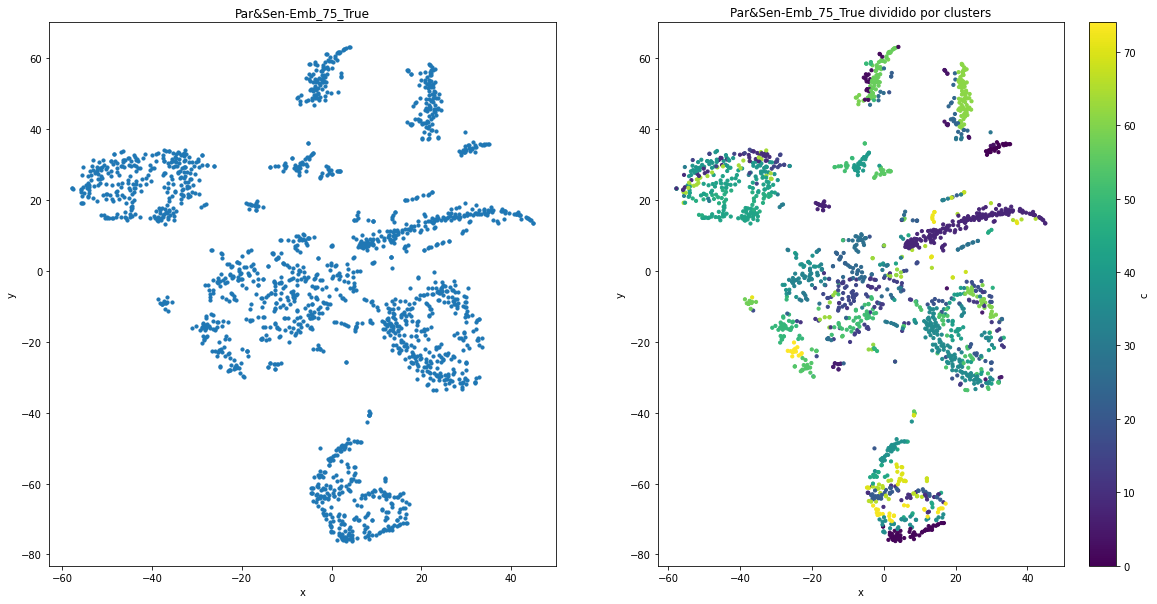

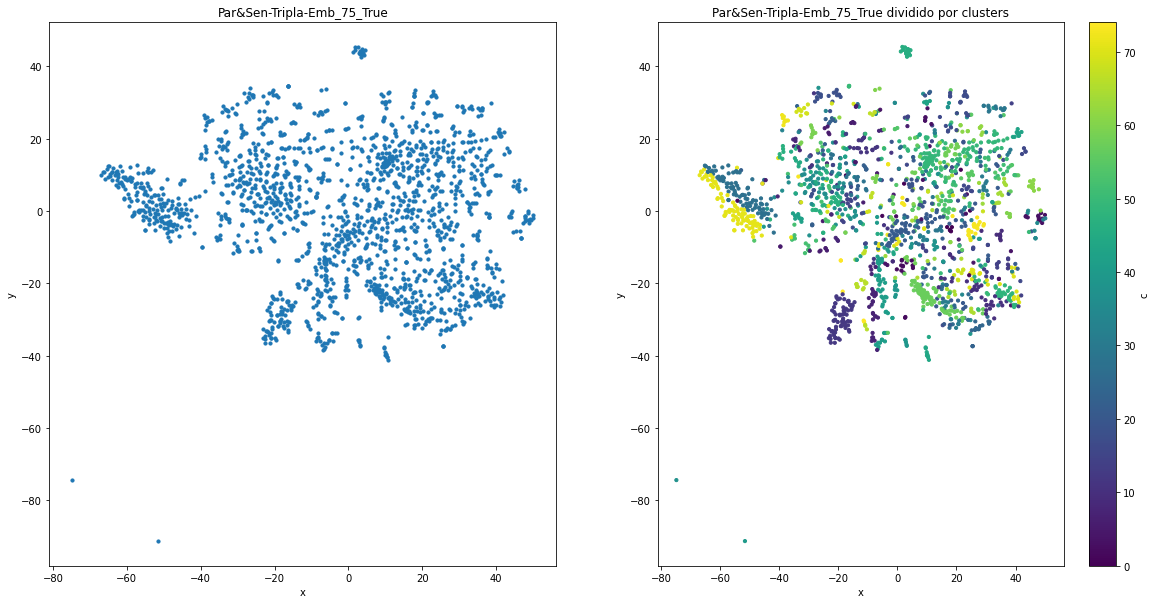

In [31]:
for m_plot in final_plots:
  pointsspacy, pointscluster = final_plots[m_plot]
  plot(pointsspacy, pointscluster, m_plot)

#Ver clusters

Funcion para ver las palabras de un cluster.

In [41]:
def get_cluster(my_word, clusters, key_words):
  my_lemma = nlp(my_word)[0].lemma_
  cluster_w = [lemma for lemma in key_words if clusters[key_words[lemma]] == clusters[key_words[my_lemma]]]
  print(f'Cluster de "{my_word}":')
  print(f'{cluster_w}')

Veremos los clusters interesantes del grupo con mejor rendimiento final, que fue el de Parrafos y oraciones, sin la tripla de dependencia y sin el embedding.

Podemos ver que con los dias de la semana tambien se encuentran los meses.

Tambien que en el mismo cluster que juez se encuentran palabras como 'policía', 'fiscal', 'guardia', 'dirigente', 'periodista', 'economista', 'intendente'.

Y Que en el cluster de ocasionar se encuentran verbos que se usan en contextos juridicos, por ejemplo: 'provocar', 'complicar', 'pretender',  'enfrentar', 'adjudicar', 'ocasionar', 'implicar'.

Ademas de los clusters de nombres propios y de funcionarios publicos elegidos.

In [42]:
# Stopwords
get_cluster("de", m_clusters, m_key_words)
#Dias de la semana
get_cluster("lunes", m_clusters, m_key_words)
# figuras publicas
get_cluster("juez", m_clusters, m_key_words)
#policiales
get_cluster("ocasionar", m_clusters, m_key_words)
#Nombres propios
get_cluster("Walter", m_clusters, m_key_words)
# Funcionarios públicos Brasil
get_cluster("Lula", m_clusters, m_key_words)
# Funcionarios públicos Cordoba
get_cluster("Schiaretti", m_clusters, m_key_words)

Cluster de "de":
['Lo', 'que', 'a', 'lo', 'el', 'y', 'no', 'se', 'sin', 'ni', 'cuatro', 'Se', 'en', 'de', 'Hoy', 'del', 'sino', 'tan', 'bien', 'les', 'Qué', 'Me', 'siempre', 'uno', 'cuando', 'pero', 'ya', 'más', 'A', 'me', 'No', 'comer', 'parir', 'los', 'con', 'ese', 'al', 'Sin', 'Después', 'te', 'do', 'sólo', 'También', 'por', 'Los', 'también', 'si', 'Es', 'El', 'cada', 'qué', 'ahora', 'menos', 'Cuando', 'o', 'aunque', 'nunca', 'En', 'Siempre', 'Y', 'La', 'ayer', 'Así', 'tres', 'Si', 'desde', 'Que', 'entrar', 'Ese', 'porque', 'le', 'Pero', 'cincar', 'mil', 'su', 'este', 'asir', 'después', 'recién', 'Yo', 'muy', 'nosotros', 'Por', 'hoy', 'durante', 'sobrar', 'mediante', 'De', 'quien', 'Las', 'hasta', 'yo', 'Entre', 'Uno', 'Sólo', 'nuestro', 'luego', 'Aunque', 'antes', 'mi', 'apenar', 'Ahora', 'Ya', 'Son', 'atrás', 'e', 'Además', 'ciento', 'todavía', 'Cada', 'casi', 'Allí', 'Según', 'ocho', 'Con', 'Para', 'Nosotros', 'seis', 'según', 'Como', 'Una', 'Este', 'además', 'cualquiera', 'Desde

Luego para comparar los metodos finales se muestran los clusters con cada metodo, siendo el primero sin ningun adherido, el segundo usando tripla, el tercero usando solo embedding y el cuarto usando tripla y embedding.

In [33]:
# Stopwords
get_cluster("de", m_clusters, m_key_words)
get_cluster("de", tripla_clusters, tripla_m_key_words)
get_cluster("de", emb_clusters, m_key_words)
get_cluster("de", tripla_emb_clusters, tripla_m_key_words)

Cluster de "de":
['Lo', 'que', 'a', 'lo', 'el', 'y', 'no', 'se', 'sin', 'ni', 'cuatro', 'Se', 'en', 'de', 'Hoy', 'del', 'sino', 'tan', 'bien', 'les', 'Qué', 'Me', 'siempre', 'uno', 'cuando', 'pero', 'ya', 'más', 'A', 'me', 'No', 'comer', 'parir', 'los', 'con', 'ese', 'al', 'Sin', 'Después', 'te', 'do', 'sólo', 'También', 'por', 'Los', 'también', 'si', 'Es', 'El', 'cada', 'qué', 'ahora', 'menos', 'Cuando', 'o', 'aunque', 'nunca', 'En', 'Siempre', 'Y', 'La', 'ayer', 'Así', 'tres', 'Si', 'desde', 'Que', 'entrar', 'Ese', 'porque', 'le', 'Pero', 'cincar', 'mil', 'su', 'este', 'asir', 'después', 'recién', 'Yo', 'muy', 'nosotros', 'Por', 'hoy', 'durante', 'sobrar', 'mediante', 'De', 'quien', 'Las', 'hasta', 'yo', 'Entre', 'Uno', 'Sólo', 'nuestro', 'luego', 'Aunque', 'antes', 'mi', 'apenar', 'Ahora', 'Ya', 'Son', 'atrás', 'e', 'Además', 'ciento', 'todavía', 'Cada', 'casi', 'Allí', 'Según', 'ocho', 'Con', 'Para', 'Nosotros', 'seis', 'según', 'Como', 'Una', 'Este', 'además', 'cualquiera', 'Desde

Se puede ver que en los metodos con tripla tenemos ademas de los dias de la semana, muchas palabras mas, lo cual no es lo deseado.

In [34]:
# Días de la semana
get_cluster("lunes", m_clusters, m_key_words)
get_cluster("lunes", tripla_clusters, tripla_m_key_words)
get_cluster("lunes", emb_clusters, m_key_words)
get_cluster("lunes", tripla_emb_clusters, tripla_m_key_words)

Cluster de "lunes":
['sábado', 'miércoles', 'septiembre', 'martes', 'diciembre', 'viernes', 'octubre', 'lunes', 'abril', 'agostar', 'jueves', 'marzo', 'enero', 'junio', 'julio', 'noviembre', 'domingo', 'mayar']
Cluster de "lunes":
['martes', 'pelear', 'pendiente', 'época', 'estancia', 'presenciar', 'lunes', 'Río', 'intervención', 'Secretaría', 'objetivar', 'ideo', 'documentación', 'sedar', 'salariar', 'intención', 'respaldar', 'obligación', 'avisar', 'raíz', 'motivo', 'contactar', 'Cómo', 'conferenciar', 'consideración', 'proveedor', 'detallar', 'operación']
Cluster de "lunes":
['sábado', 'miércoles', 'septiembre', 'martes', 'diciembre', 'viernes', 'lunes', 'abril', 'agostar', 'jueves', 'marzo', 'enero', 'junio', 'julio', 'noviembre', 'domingo', 'mayar']
Cluster de "lunes":
['manera', 'sábado', 'miércoles', 'refacción', 'mesar', 'cómo', 'diciembre', 'presenciar', 'salar', 'lunes', 'abril', 'agostar', 'jueves', 'semana', 'mes', 'presentación', 'sedar', 'caja', 'función', 'localidad', 'r

En el de nombres propios, vemos que el metodo sin adiciones fue el que tiene mas palabras, pero aqui es totalmente correcto ya que todos son nombres propios.

In [36]:
#Nombres propios
get_cluster("Walter", m_clusters, m_key_words)
get_cluster("Walter", tripla_clusters, tripla_m_key_words)
get_cluster("Walter", emb_clusters, m_key_words)
get_cluster("Walter", tripla_emb_clusters, tripla_m_key_words)

Cluster de "Walter":
['unir', 'Manuel', 'Alejandro', 'Luis', 'Nicolás', 'Daniel', 'Santa', 'Alfredo', 'coordinador', 'Carlos', 'Roberto', 'José', 'Garzón', 'Colón', 'Martín', 'Dos', 'Cristina', 'Néstor', 'K', 'Oscar', 'Gustavo', 'Hugo', 'Juan', 'Eduardo', 'Walter', 'Ricardo', 'Marcelo', 'Nobel', 'Liu', 'Twitter', 'Fernando', 'foto', 'Rafael', 'Jorge', 'Miguel', 'Macri', 'Sergio', 'Héctor', 'Alberto', 'Raúl', 'Indra', 'Jaime', 'Julio', 'militante', 'Fiesta', 'Mario', 'Economía']
Cluster de "Walter":
['Carbó', 'Manuel', 'Alejandro', 'Jerónimo', 'Daniel', 'Carlos', 'Roberto', 'cámara', 'K', 'Oscar', 'Gustavo', 'Hugo', 'Juan', 'integrante', 'Walter', 'Twitter', 'Juárez', 'Jorge', 'Miguel', 'Macri', 'Héctor', 'Moreno', 'Julio', 'Fiesta', 'Mario', 'comisario']
Cluster de "Walter":
['unir', 'Manuel', 'Alejandro', 'Daniel', 'Alfredo', 'Carlos', 'Roberto', 'José', 'Colón', 'Cristina', 'K', 'Oscar', 'Gustavo', 'Hugo', 'Juan', 'Eduardo', 'Walter', 'Ricardo', 'Marcelo', 'Twitter', 'Fernando', 'fot

In [37]:
# Funcionarios públicos Brasil
get_cluster("Lula", m_clusters, m_key_words)
get_cluster("Lula", tripla_clusters, tripla_m_key_words)
get_cluster("Lula", emb_clusters, m_key_words)
get_cluster("Lula", tripla_emb_clusters, tripla_m_key_words)

Cluster de "Lula":
['Ambiente', 'Marina', 'Brasilia', 'Silva', 'PV', 'Dilma', 'Rousseff', 'Serra', 'PT', 'PSDB', 'Luiz', 'Lula']
Cluster de "Lula":
['Martínez', 'forzar', 'coordinador', 'Cristina', 'Fernández', 'Néstor', 'Ricardo', 'Marcelo', 'Lula', 'Fernando', 'foto', 'Rafael', 'Sergio', 'Jaime', 'Piñera', 'Correa', 'Gutiérrez', 'Economía', 'Grupo']
Cluster de "Lula":
['Luis', 'Nicolás', 'Santa', 'San', 'Francisco', 'Martín', 'Néstor', 'Día', 'Nobel', 'Liu', 'Dilma', 'Luiz', 'Lula', 'Macri', 'Piñera', 'Julio', 'Correa', 'Quito', 'Mario', 'Iberia', 'Bunge', 'Economía', 'Aerolíneas', 'Maidana']
Cluster de "Lula":
['Pedro', 'María', 'Yo', 'Roberto', 'José', 'Agricultura', 'Cristina', 'Fernández', 'Kirchner', 'Cámara', 'Néstor', 'Oscar', 'Municipalidad', 'Marcelo', 'Rousseff', 'Serra', 'Lula', 'Fernando', 'Policía', 'Conare', 'Piñera', 'Moreno', 'López', 'Sala', 'Correa', 'Gutiérrez', 'Bunge', 'Campana']


Por ultimo podemos ver una vez mas, en el cluster de Funcionarios públicos Cordoba que el metodo con tripla de dependencia tiene muchas palabras, las cuales no esperabamos. Aunque se formo ungrupo interesante ya que estan alli las palabras  'Gobierno', 'Córdoba',  'Provincial', 'Educación', 'Ciencias', 'Facultad', 'Provincia', 'Plaza', 'Mundial', 'Nacional', 'Peronismo', 'Federal', 'Electoral'
que estan claramente relacionadas.

In [38]:
# Funcionarios públicos Cordoba
get_cluster("Schiaretti", m_clusters, m_key_words)
get_cluster("Schiaretti", tripla_clusters, tripla_m_key_words)
get_cluster("Schiaretti", emb_clusters, m_key_words)
get_cluster("Schiaretti", tripla_emb_clusters, tripla_m_key_words)

Cluster de "Schiaretti":
['Kirchner', 'Díaz', 'Sota', 'Schiaretti', 'Mestre', 'Vigo', 'Primero', 'Giacomino', 'Nuestra', 'Campana']
Cluster de "Schiaretti":
['Belgrano', 'Luis', 'Cabrera', 'Educación', 'Gobierno', 'Unidos', 'Córdoba', 'Nicolás', 'Pedro', 'Rodríguez', 'María', 'Provincial', 'Ciencias', 'Facultad', 'García', 'Alta', 'Gracia', 'Cruz', 'Santa', 'Internacional', 'Provincia', 'Punilla', 'Plaza', 'Mundial', 'Nacional', 'Dirección', 'San', 'Francisco', 'Cuarto', 'Ambiente', 'Suprema', 'UNC', 'Francia', 'Argentinas', 'José', 'Agulla', 'Pablo', 'General', 'Martín', 'Comercio', 'Interior', 'Sur', 'Servicios', 'Voz', 'Afip', 'Estado', 'Judicial', 'Aires', 'Cívico', 'Juez', 'Díaz', 'Peronismo', 'Federal', 'Electoral', 'Sota', 'Schiaretti', 'Mestre', 'Públicos', 'Giacomino', 'Deliberante', 'Norte', 'Turismo', 'Allende', 'Naciones', 'Nobel', 'Silva', 'Rousseff', 'Democracia', 'Brasileña', 'Inácio', 'Janeiro', 'Fiat', 'Europa', 'Perón', 'Banco', 'Guerra', 'Chávez', 'Latinoamérica', 'D